In [10]:
import torch
from torch.utils.data import Dataset,DataLoader,TensorDataset,Subset
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
from torch.nn import Module,ReLU,Linear
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [11]:
data=pd.read_csv('./data/data_process/data.csv',encoding='utf-8')
data.drop('控制人ID',axis=1,inplace=True) 
#这里是数据处理的时候失误了，没有把控制人ID给去掉
data

,flag,控制人持股比例,注册时间,注册资本,专利,商标,著作权,2015_债权融资成本,2015_债权融资额度,2015_内部融资和贸易融资成本,...,股份有限公司,集体所有制企业,企业法人,自然人,交通运输业,商业服务业,工业,服务业,社区服务,零售业
0,1.0,0.89,2010.0,6680.0,0.0,0.0,0.0,0.0,0.0,0.000,...,1,0,0,1,0,1,0,0,0,0
1,1.0,0.58,2001.0,7730.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0,1,1,0,0,0,1,0,0,0
2,1.0,0.84,2002.0,6840.0,0.0,1.0,1.0,0.0,0.0,29450.304,...,0,0,0,1,0,0,1,0,0,0
3,1.0,0.81,2011.0,6120.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0,1,1,0,1,0,0,0,0,0
4,1.0,0.56,2001.0,8430.0,1.0,1.0,0.0,0.0,0.0,0.000,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17101,0.0,0.65,2011.0,2960.0,0.0,0.0,0.0,0.0,0.0,0.000,...,1,0,1,0,0,1,0,0,0,0
17102,0.0,0.83,2000.0,9650.0,0.0,1.0,1.0,0.0,0.0,0.000,...,0,0,1,0,0,0,1,0,0,0
17103,0.0,0.93,2011.0,2170.0,1.0,1.0,0.0,0.0,0.0,0.000,...,0,0,0,1,0,0,0,0,0,1
17104,0.0,0.73,2013.0,9030.0,1.0,1.0,0.0,0.0,0.0,7151.760,...,0,1,1,0,1,0,0,0,0,0


In [12]:
torch.cuda.is_available()

False

In [13]:
#torch.cuda.get_device_name(0)

In [14]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device=torch.device(dev)

In [15]:
class Data(Dataset):
    def __init__(self,data):
        super().__init__()
        self.ds_demo=data.values
        self.y_raw=self.ds_demo[:,0]
        self.x_raw=self.ds_demo[:,1:]
        self.max_array=self.ds_demo.max(axis=0)
        self.min_array=self.ds_demo.min(axis=0)
        self.data_shape=self.ds_demo.shape
        self.data=np.empty_like(self.ds_demo)
        for i in range(self.data_shape[1]-1):
            self.data[:,i]=(self.ds_demo[:,i+1]-self.min_array[i+1])/(self.max_array[i+1]-self.min_array[i+1])
        self.data[:,-1]=self.ds_demo[:,0]
        #以上是完成特征值的归一化
        self.data=torch.tensor(self.data,dtype=torch.float32).to(device)
    def __len__(self):
        return len(self.ds_demo)
    def __getitem__(self,index):
        return self.data[index,0:-1],self.data[index,-1]

ds=Data(data)

bs=16
#批处理大小为16

ds_train=Subset(dataset=ds,indices=range(15000))
ds_valid=Subset(dataset=ds,indices=range(15000,len(ds)))
dl_train=DataLoader(ds_train,batch_size=bs,shuffle=True)
dl_valid=DataLoader(ds_valid,batch_size=bs*2)
dl_train_fullsize=DataLoader(ds_train,batch_size=len(ds_train))
dl_valid_fullsize=DataLoader(ds_valid,batch_size=len(ds_valid))

In [16]:
class Company_Classifier(Module):
    def __init__(self):
        super().__init__()
        self.l1=Linear(70,64) 
        self.r1=ReLU()
        self.l2=Linear(64,32)
        self.r2=ReLU()
        self.l3=Linear(32,16)
        self.r3=ReLU()
        self.l4=Linear(16,8)
        self.r4=ReLU()
        self.l5=Linear(8,4)
        self.r5=ReLU()
        self.l6=Linear(4,2)
    def forward(self,x):
        x=self.l1(x)
        x=self.r1(x)
        x=self.l2(x)
        x=self.r2(x)
        x=self.l3(x)
        x=self.r3(x)
        x=self.l4(x)
        x=self.r4(x)
        x=self.l5(x)
        x=self.r5(x)
        x=self.l6(x)
        x=torch.sigmoid(x)
        return x

In [17]:
model=Company_Classifier().to(device)

def Accuracy(preds,yb):
    out=torch.argmax(preds,dim=-1)
    return (out==yb).float().mean()
#评估准确率的函数

epochs=20
#迭代20个epoch

loss_history=[]
valid_loss_history=[]
train_loss_history=[]

accuracy_history=[]
valid_accuracy_history=[]
train_accuracy_history=[]

loss_func=F.cross_entropy

opt=optim.Adam(model.parameters())
#使用Adam优化算法

for epoch in range(epochs):
    model.train()
    for xb,yb in dl_train:
        Input=xb.to(device)
        Target=yb.to(device)
        Output=model(Input)
        loss=loss_func(Output,Target.long())
        accuracy=Accuracy(Output,Target)
        print(loss)
        
        #loss_history.append(loss)
        #accuracy_history.append(accuracy)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval() #每个epoch训练完之后评估模型性能
    valid_loss=sum(loss_func(model(xb),yb.long()) for xb,yb in dl_valid)/len(dl_valid)
    valid_loss_history.append(valid_loss)
    train_loss=sum(loss_func(model(xb),yb.long()) for xb,yb in dl_train)/len(dl_train)
    train_loss_history.append(train_loss)
    
    for xb,yb in dl_valid_fullsize:
        Input=xb.to(device)
        Target=yb.to(device)
        Output=model(Input)
        accuracy=Accuracy(Output,Target)
        valid_accuracy_history.append(accuracy)
    for xb,yb in dl_train_fullsize:
        Target=yb.to(device)
        Input=xb.to(device)
        Output=model(Input)
        accuracy=Accuracy(Output,Target)
        train_accuracy_history.append(accuracy)

kward>)
tensor(0.3981, grad_fn=<NllLossBackward>)
tensor(0.3135, grad_fn=<NllLossBackward>)
tensor(0.3145, grad_fn=<NllLossBackward>)
tensor(0.4066, grad_fn=<NllLossBackward>)
tensor(0.3263, grad_fn=<NllLossBackward>)
tensor(0.4346, grad_fn=<NllLossBackward>)
tensor(0.3477, grad_fn=<NllLossBackward>)
tensor(0.3432, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.3135, grad_fn=<NllLossBackward>)
tensor(0.3355, grad_fn=<NllLossBackward>)
tensor(0.3745, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.3134, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.3757, grad_fn=<NllLossBackward>)
tensor(0.3757, grad_fn=<NllLossBackward>)
tensor(0.3596, grad_fn=<NllLossBackward>)
tensor(0.3760, grad_fn=<NllLossBackward>)
tensor(0.3756, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<Nl

result

[tensor(0.3629, grad_fn=<DivBackward0>), tensor(0.3393, grad_fn=<DivBackward0>), tensor(0.3285, grad_fn=<DivBackward0>), tensor(0.3387, grad_fn=<DivBackward0>), tensor(0.3250, grad_fn=<DivBackward0>), tensor(0.3536, grad_fn=<DivBackward0>), tensor(0.3739, grad_fn=<DivBackward0>), tensor(0.3236, grad_fn=<DivBackward0>), tensor(0.3585, grad_fn=<DivBackward0>), tensor(0.3188, grad_fn=<DivBackward0>), tensor(0.3465, grad_fn=<DivBackward0>), tensor(0.3806, grad_fn=<DivBackward0>), tensor(0.3484, grad_fn=<DivBackward0>), tensor(0.3238, grad_fn=<DivBackward0>), tensor(0.3361, grad_fn=<DivBackward0>), tensor(0.3317, grad_fn=<DivBackward0>), tensor(0.3483, grad_fn=<DivBackward0>), tensor(0.3409, grad_fn=<DivBackward0>), tensor(0.3419, grad_fn=<DivBackward0>), tensor(0.3259, grad_fn=<DivBackward0>)]
[tensor(0.9554), tensor(0.9725), tensor(0.9862), tensor(0.9734), tensor(0.9886), tensor(0.9592), tensor(0.9359), tensor(0.9891), tensor(0.9525), tensor(0.9948), tensor(0.9644), tensor(0.9311)

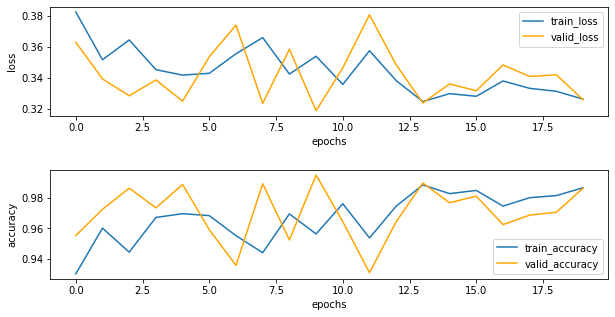

In [19]:
print("result")
print()

fig=plt.figure(figsize=(10,5))

plt.subplots_adjust(wspace=0.2,hspace=0.5)

ax1=fig.add_subplot(2,1,1)
plt.plot(range(len(train_loss_history)),train_loss_history)
plt.plot(range(len(valid_loss_history)),valid_loss_history,'orange')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss','valid_loss'])

ax2=fig.add_subplot(2,1,2)
plt.plot(range(len(train_accuracy_history)),train_accuracy_history)
plt.plot(range(len(valid_accuracy_history)),valid_accuracy_history,'orange')
plt.xlabel('epochs')
plt.ylabel('accuracy')
ax2.legend(['train_accuracy','valid_accuracy'])

print(valid_loss_history)
print(valid_accuracy_history)